In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
data_filename = 'day9_heightmap.txt'
with open(data_filename) as datafile:
    data = [l.strip() for l in datafile.readlines()]

In [3]:
heights = np.array([[int(h) for h in row] for row in data])

In [4]:
heights.shape

(100, 100)

# Part 1

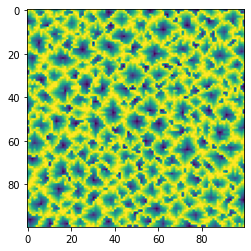

In [5]:
plt.imshow(heights)

In [6]:
def xy_in_bounds(x, y, heights=heights):
    if x < 0 or x >= heights.shape[0]:
        return False
    elif y < 0 or y >= heights.shape[1]:
        return False
    else:
        return True

In [7]:
def find_neighbours(x, y, heights=heights):
    neighbours = np.array([(x-1, y), (x+1, y),
                           (x, y-1), (x, y+1)])
    neighbours = [n for n in neighbours if xy_in_bounds(*n, heights)]
    return neighbours

In [8]:
def is_low(x, y, heights=heights):
    neighbours = find_neighbours(x, y, heights)
    if (np.array([heights[x,y] for x,y in neighbours]) >
        heights[x,y]).all():
        return True
    else:
        return False

In [9]:
is_low(5,5)

False

In [10]:
lows = np.zeros_like(heights).astype(bool)
for i in range(100):
    for j in range(100):
        lows[i,j] = is_low(i, j)

In [11]:
lows.sum()

249

In [12]:
(heights[lows] + 1).sum()

607

# Part 2

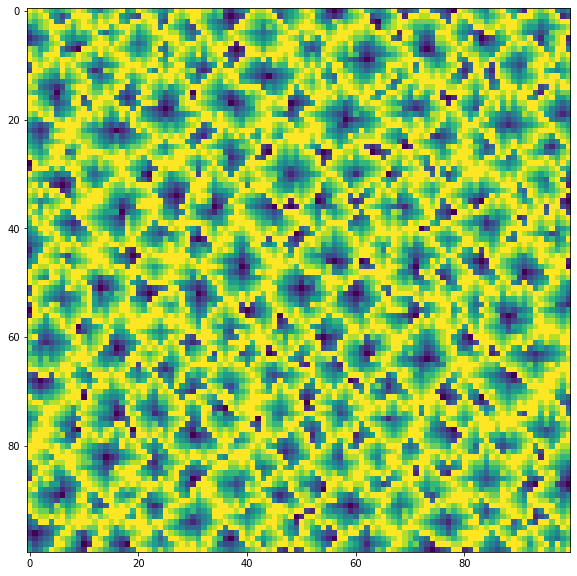

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(heights)

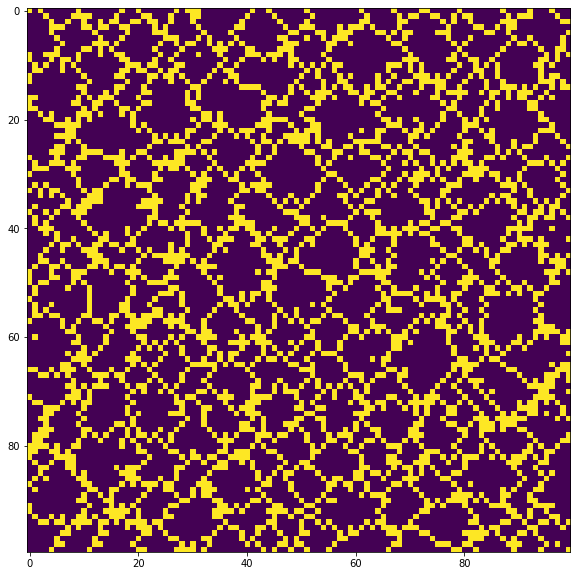

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(heights==9)

In [15]:
def find_neighbours_unexplored(x, y, explored, heights=heights):
    neighbours = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]
    neighbours = [n for n in neighbours if xy_in_bounds(*n, heights)]
    neighbours = [n for n in neighbours if not explored[n]]
    return neighbours

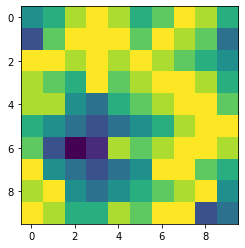

In [16]:
sample = heights[5:15, 10:20]
s_lows = lows[5:15, 10:20]
plt.imshow(sample)

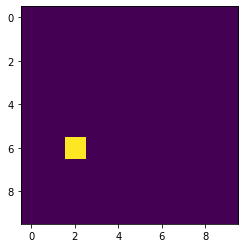

In [17]:
plt.imshow(s_lows)

### Setup

In [18]:
low_locs = list(zip(*np.where(s_lows)))

# Array to store places already checked (or 9)
explored = sample==9

basin_size = 1
loc = low_locs[0]
explored[loc] = True
to_check = []

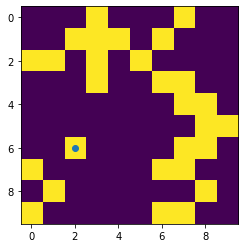

In [19]:
plt.imshow(explored)
plt.scatter(loc[1], loc[0])

### Single step

In [20]:
def step(loc, basin_size):
    neighbours = find_neighbours_unexplored(*loc, explored, sample)
    print(neighbours)

    basin_size += len(neighbours)
    for n in neighbours:
        explored[n] = True
    to_check.extend(neighbours)
    
    #plt.imshow(explored)
    #plt.scatter(loc[1], loc[0])

In [21]:
while len(to_check) > 0:
    loc = to_check.pop()
    step(loc)

In [22]:
to_check

[]

In [23]:
basin_size

1

### Now seriously

In [24]:
def step(loc, basin_size, explored, to_check):
    neighbours = find_neighbours_unexplored(*loc, explored, heights)

    basin_size += len(neighbours)
    for n in neighbours:
        explored[n] = True
    to_check.extend(neighbours)
    
    return basin_size, explored, to_check

In [25]:
low_locs = list(zip(*np.where(lows)))

In [64]:
# Array to store places already checked (or 9)
explored = heights == 9

all_sizes = []
for loc in low_locs:
    basin_size = 1
    explored[loc] = True
    to_check = [loc]

    while len(to_check) > 0:
        loc = to_check.pop()
        basin_size, explored, to_check = step(loc, basin_size, explored, to_check)
        
    all_sizes.append(basin_size)

In [65]:
t1, t2, t3 = np.sort(all_sizes)[-3:]
t1, t2, t3

(92, 96, 102)

In [66]:
t1*t2*t3

900864

### Try a BFS/floodfill approach

In [30]:
from collections import deque

In [70]:
%%timeit
explored = set()
#explored = heights == 9 # minimally faster with array lookup
sizes = []

for row, col in low_locs:
    q = deque()
    size = 0
    if (row, col) not in explored:
    #if not explored[row, col]:
        q.append((row,col))
    while q:
        row, col = q.popleft()
        if (row, col) in explored:
        #if explored[row, col]:
            continue
        else:
            explored.add((row, col))
            #explored[row, col] = True
            size += 1
            # add neighbours to queue
            for dd in [(0,1), (1,0), (0,-1), (-1,0)]:
                rr = row + dd[0]
                cc = col + dd[1]
                if (0 <= rr < heights.shape[0] and
                    0 <= cc < heights.shape[1] and
                    heights[rr, cc] != 9):
                    q.append((rr, cc))
    sizes.append(size)

48.7 ms ± 2.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [71]:
t1, t2, t3 = np.sort(all_sizes)[-3:]
print(t1, t2, t3)
t1*t2*t3

92 96 102


900864

# Make the animation

In [26]:
from PIL import Image
import imageio

In [ ]:
# Array to store places already checked (or 9)
explored = heights == 9
#fig, ax = plt.subplots(figsize=(10,10))
filenames = []
frame_counter = 0

all_sizes = []
for loc in low_locs:
    basin_size = 1
    explored[loc] = True
    to_check = [loc]

    while len(to_check) > 0:
        loc = to_check.pop()
        basin_size, explored, to_check = step(loc, basin_size, explored, to_check)
        
        # Save animation frame
        if frame_counter > 0:
            filename = f'animation/{frame_counter}.png'
            filenames.append(filename)
            #ax.imshow(explored)
            #fig.savefig(filename)
            img_array = np.kron(~explored, np.ones([4,4]))
            img = Image.fromarray((img_array * 255).astype(np.uint8))
            img.save(filename)
        frame_counter += 1
        
    all_sizes.append(basin_size)

In [295]:
#with imageio.get_writer('animation_day9.gif', mode='I', duration=) as writer:
images = []
for filename in filenames[::5]:
    image = imageio.imread(filename)
    #writer.append_data(image)
    images.append(image)
imageio.mimsave('animation_day9_sub.gif', images, fps=55)